In [2]:
#%% ---------------------------------------------------------------------------
# desatml2.py  –  binary‑desaturation model for two data‑sets (SIesta & ESADA)
# ---------------------------------------------------------------------------

#%% ---------------------------------------------------------------------------
# Imports & utility callbacks
# ---------------------------------------------------------------------------
from __future__ import absolute_import, division, print_function
import os
import numpy as np
import keras
from datetime import datetime
import h5py
import pandas as pd                     # pandas for the results DataFrame

# scikit‑learn metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# ---------------------------------------------------------------------------
# Helper callbacks
# ---------------------------------------------------------------------------
class PrintDot(keras.callbacks.Callback):
    """Print a dot every epoch (newline every 100 epochs)."""
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            print(' ')
        print('#', end='')


class PrintBestEpoch(keras.callbacks.Callback):
    """Keeps track of the epoch with the lowest validation loss."""
    def on_train_begin(self, logs=None):
        self.best_value = np.inf
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.best_value:
            self.best_value = val_loss
            self.best_epoch = epoch

    def on_train_end(self, logs=None):
        print(f'Best epoch: {self.best_epoch + 1}')


#%% ---------------------------------------------------------------------------
# Hyper‑parameters (shared by both data‑sets)
# ---------------------------------------------------------------------------
VAL_SPLIT = 0.1
BATCH_SIZE = 20000
EPOCHS = 1000
EARLY_STOP_PATIENCE = 100
LRN_RATE = 0.0002
INPUT_DIM = 300          # each row in the DataMatrix files has 300 columns
NUM_CLASSES = 2          # binary classification


#%% ---------------------------------------------------------------------------
# Model definition (binary only)
# ---------------------------------------------------------------------------
def build_binary_model():
    """Return a compiled Keras model for the binary task."""
    model = keras.Sequential([
        keras.layers.Dense(30, activation='tanh', input_shape=(INPUT_DIM,)),
        keras.layers.Dense(10, activation='tanh'),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    optimizer = keras.optimizers.Adam(LRN_RATE)
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    model.summary()
    return model


#%% ---------------------------------------------------------------------------
# Training helper
# ---------------------------------------------------------------------------
def train_model(model, train_X, train_y_onehot,
                model_path, weights_path):
    """Fit the model with early‑stopping & checkpointing."""
    print('\nTraining started at:',
          datetime.now().strftime('%d/%m/%Y %H:%M:%S'), '\n')

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOP_PATIENCE
    )
    callbacks = [
        PrintBestEpoch(),
        early_stop,
        keras.callbacks.ModelCheckpoint(
            filepath=weights_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ]

    history = model.fit(
        train_X,
        train_y_onehot,
        epochs=EPOCHS,
        validation_split=VAL_SPLIT,
        batch_size=BATCH_SIZE,
        verbose=1,
        callbacks=callbacks
    )

    # Save the final model (architecture + weights)
    model.save(model_path)
    return model, history


#%% ---------------------------------------------------------------------------
# Evaluation helper (binary) – uses scikit‑learn
# ---------------------------------------------------------------------------
def evaluate_binary(model_path, test_X, test_y):
    """
    Load a saved model, predict on test data and return a dict with
    accuracy, precision, recall and F1‑score (computed by scikit‑learn).
    """
    model = keras.models.load_model(model_path)
    pred_prob = model.predict(test_X)                     # shape (N, 2)
    pred_class = np.argmax(pred_prob, axis=1)            # 0 or 1

    y_true = test_y.ravel().astype(int)

    acc  = accuracy_score(y_true, pred_class)
    prec = precision_score(y_true, pred_class, zero_division=0)
    rec  = recall_score(y_true, pred_class, zero_division=0)
    f1   = f1_score(y_true, pred_class, zero_division=0)

    summary = {
        "Accuracy":   np.round(acc,   3),
        "Precision": np.round(prec,  3),
        "Recall":    np.round(rec,   3),
        "F1‑Score":  np.round(f1,    3)
    }
    return summary


#%% ---------------------------------------------------------------------------
# Simple container for the two data‑sets
# ---------------------------------------------------------------------------
class DatasetInfo:
    """Holds file locations and a short identifier for a data‑set."""
    def __init__(self, name, data_path, label_path):
        self.name = name                # e.g. 'siesta' or 'esada'
        self.data_path = data_path
        self.label_path = label_path


# Define the two data‑sets (adjust paths if you move the script)
DATASETS = [
    DatasetInfo(
        name='siesta',
        data_path='SIESTA_4percent/DataMatrix_SpO2_cleaned4_.txt',
        label_path='SIESTA_4percent/BinaryOutput_SpO2_cleaned4_.txt'
    ),
    DatasetInfo(
        name='esada',
        data_path='ESADA_4percent/DataMatrix_SpO2_cleaned4__esada.txt',
        label_path='ESADA_4percent/BinaryOutput_SpO2_cleaned4__esada.txt'
    )
]


#%% ---------------------------------------------------------------------------
# Main driver – run the whole pipeline for each data‑set
# ---------------------------------------------------------------------------
def run_for_dataset(ds: DatasetInfo, test_fraction=0.1):
    """Load data, train binary model, evaluate and return the metric dict."""
    print('\n' + '=' * 70)
    print(f'Processing data‑set: {ds.name.upper()}')
    print('=' * 70)

    # ---- Load --------------------------------------------------------------
    X = np.loadtxt(ds.data_path, delimiter=',')
    y = np.expand_dims(np.loadtxt(ds.label_path), axis=1)

    # ---- Train / test split -------------------------------------------------
    n_samples = X.shape[0]                     # total number of samples
    n_test = int(round(test_fraction * n_samples))

    indices = np.random.permutation(n_samples)
    test_idx = indices[:n_test]
    train_idx = indices[n_test:]

    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]

    # One‑hot encode the binary labels for training
    y_train_oh = keras.utils.to_categorical(y_train, NUM_CLASSES)

    # ---- Build, train and save ------------------------------------------------
    model = build_binary_model()
    model_path   = f'{ds.name}_ml_binary.keras'   # final model
    weights_path = f'{ds.name}_wg_binary.keras'   # best‑epoch checkpoint

    model, _ = train_model(
        model,
        X_train,
        y_train_oh,
        model_path,
        weights_path
    )

    # ---- Evaluate -----------------------------------------------------------
    summary = evaluate_binary(model_path, X_test, y_test)

    # Add fields needed for the DataFrame
    summary["Dataset"] = ds.name.upper()
    summary["Samples"] = n_samples

    print(f'\nDesaturation binary model – {ds.name.upper()}')
    print(summary)

    return summary


#%% ---------------------------------------------------------------------------
# Execute for every defined data‑set and store the results in a DataFrame
# ---------------------------------------------------------------------------
if __name__ == '__main__':
    # Collect a dict for each data‑set
    results_list = []

    for ds in DATASETS:
        results_list.append(run_for_dataset(ds, test_fraction=0.1))

    # Convert the list of dicts into a pandas DataFrame
    results_df = pd.DataFrame(results_list)

    # Order columns for a tidy display
    results_df = results_df[
        ['Dataset', 'Samples', 'Accuracy', 'Precision', 'Recall', 'F1‑Score']
    ]

    # Show the DataFrame
    print("\n=== Summary of all data‑sets (pandas DataFrame) ===")
    print(results_df)

    # -----------------------------------------------------------------------
    # The DataFrame `results_df` can now be reused:
    #   results_df.to_csv('desat_metrics.csv', index=False)
    #   results_df.plot(kind='bar', x='Dataset')
    # -----------------------------------------------------------------------

2025-08-13 15:58:42.351913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 15:58:42.362040: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-13 15:58:42.371354: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-13 15:58:42.396167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755093522.437544 1926865 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755093522.44


Processing data‑set: SIESTA


/home/bowden/Code/HARPOCRATES/demonstator/Privacy-Preserving-ML-through-HHE/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-13 15:58:49.776778: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │         9,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,362 (36.57 KB)

 Trainable params: 9,362 (36.57 KB)

 Non-trainable params: 0 (0.00 B)


Training started at: 13/08/2025 15:58:50 

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.7817 - loss: 0.1922 - val_accuracy: 0.7673 - val_loss: 0.1961
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7818 - loss: 0.1850 - val_accuracy: 0.7673 - val_loss: 0.1927
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7818 - loss: 0.1819 - val_accuracy: 0.7673 - val_loss: 0.1904
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7818 - loss: 0.1795 - val_accuracy: 0.7677 - val_loss: 0.1865
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7818 - loss: 0.1753 - val_accuracy: 0.7677 - val_loss: 0.1804
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7819 - loss: 0.1700 - val_accuracy: 0.7682 - val_loss: 0.1804
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7821 - loss: 0.1721 - val_accuracy: 0.7682 - val_loss: 0.1689
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accura

/home/bowden/Code/HARPOCRATES/demonstator/Privacy-Preserving-ML-through-HHE/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 30)             │         9,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,362 (36.57 KB)

 Trainable params: 9,362 (36.57 KB)

 Non-trainable params: 0 (0.00 B)


Training started at: 13/08/2025 16:01:46 

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step - accuracy: 0.2238 - loss: 0.4327 - val_accuracy: 0.2215 - val_loss: 0.4265
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.2239 - loss: 0.4250 - val_accuracy: 0.2215 - val_loss: 0.4187
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.2239 - loss: 0.4171 - val_accuracy: 0.2215 - val_loss: 0.4105
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2239 - loss: 0.4090 - val_accuracy: 0.2215 - val_loss: 0.4028
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.2239 - loss: 0.4011 - val_accuracy: 0.2215 - val_loss: 0.3950
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2239 - loss: 0.3934 - val_accuracy: 0.2215 - val_loss: 0.3871
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.2239 - loss: 0.3856 - val_accuracy: 0.2215 - val_loss: 0.3792
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accura

In [4]:
# --------------------------------------------------------------
# Cell – Plot overall metrics (matplotlib only)
# --------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_overall_metrics(df: pd.DataFrame, ax=None, show_samples=True):
    """
    Draw a grouped bar chart of the classification metrics for each data‑set.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain the columns:
        ['Dataset', 'Accuracy', 'Precision', 'Recall', 'F1‑Score'].
        An optional column ``Samples`` can be present – it will be displayed
        as ``n=…`` above each group.
    ax : matplotlib.axes.Axes, optional
        Axis on which to draw the plot. If ``None`` a new figure/axis is created.
    show_samples : bool, optional
        If True and the column ``Samples`` exists, annotate the total number
        of samples for each data‑set.

    Returns
    -------
    matplotlib.axes.Axes
        The axis containing the plot.
    """
    # ------------------------------------------------------------------
    # 1️⃣  Prepare the axis
    # ------------------------------------------------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    # ------------------------------------------------------------------
    # 2️⃣  Normalise column names (lower‑case) for internal use
    # ------------------------------------------------------------------
    # The original helper expects lower‑case column names; we map them here.
    col_map = {
        'Dataset'   : 'dataset',
        'Accuracy'  : 'accuracy',
        'Precision' : 'precision',
        'Recall'    : 'recall',
        'F1‑Score'  : 'f1'          # note the dash in the original column name
    }
    # Create a temporary DataFrame with the expected column names
    tmp = df.rename(columns=col_map)

    # ------------------------------------------------------------------
    # 3️⃣  Plot the grouped bars
    # ------------------------------------------------------------------
    metrics   = ["accuracy", "precision", "recall", "f1"]
    n_metrics = len(metrics)

    datasets = tmp["dataset"].tolist()
    n_dsets  = len(datasets)

    ind   = np.arange(n_dsets)          # the x locations for the groups
    width = 0.18                         # the width of each bar

    # colour cycle – matplotlib default is fine, but you can customise here
    colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for i, metric in enumerate(metrics):
        ax.bar(
            ind + i * width,
            tmp[metric],
            width,
            label=metric.upper(),
            color=colours[i % len(colours)]
        )

    # ------------------------------------------------------------------
    # 4️⃣  Optional sample‑size annotation
    # ------------------------------------------------------------------
    if show_samples and "Samples" in df.columns:
        for i, dataset in enumerate(datasets):
            n = df.loc[df["Dataset"] == dataset, "Samples"].values[0]
            # place the text a little above the highest bar in the group
            ymax = tmp.loc[tmp["dataset"] == dataset, metrics].max().max()
            ax.text(i + width * (n_metrics - 1) / 2,
                    ymax + 0.02,
                    f"n={int(n)}",
                    ha="center", va="bottom",
                    fontsize=9, color="gray")

    # ------------------------------------------------------------------
    # 5️⃣  Cosmetics
    # ------------------------------------------------------------------
    ax.set_xticks(ind + width * (n_metrics - 1) / 2)
    ax.set_xticklabels(datasets, rotation=0)
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1.05)                     # scores are in [0, 1]
    ax.set_title("Overall metrics (concatenated predictions)")
    ax.legend(loc="upper right", fontsize="small", ncol=2)

    plt.tight_layout()
    plt.show()

    return ax

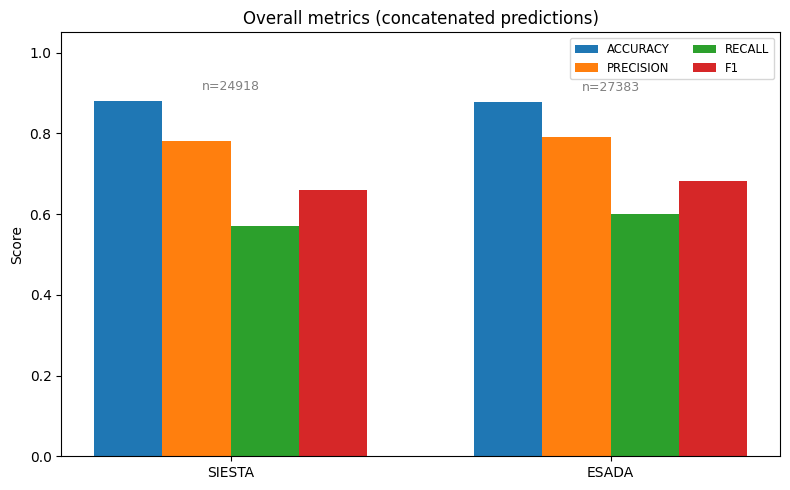

<Axes: title={'center': 'Overall metrics (concatenated predictions)'}, ylabel='Score'>

In [5]:
plot_overall_metrics(results_df)